# Orientation Recognition
Learning enough keras to recognise ~digits~ orientations.

As with the digit recognition, the approach is mostly based on the [Simple MNIST convnet](https://keras.io/examples/vision/mnist_convnet/) guide. It was this model I initially added the extra dense layer to, but it also seemed to improve the digit recognition, so now they both have it.

This is basically the exact same as the digit recognition except I create the rotations (0/90/180/270) after augmenting the data and replace the digit labels with the orientations:

|label|orientation (degs)|
|---|---|
|0|0|
|1|270|
|2|180|
|3|90|

(anticlockwise because that's the direction OpenCV rotates)


Apparently I could create a forked model if I didn't use keras' sequential API. This would avoid me needing 2 models, but I'm saving that for a rainy day.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers

2024-06-06 08:24:58.573273: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-06 08:24:58.855223: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("TMNIST_DATA.csv")
df

,names,labels,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,GrandHotel-Regular,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,EncodeSansCondensed-Medium,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Varela-Regular,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ArefRuqaa-Bold,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,KulimPark-Regular,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29895,Raleway[wght],7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29896,Charm-Regular,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29897,BigShouldersStencilDisplay-Black,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29898,Gabriela-Regular,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
digits = df.drop(["names", "labels"], axis=1)
labels = df["labels"]

digits = digits.to_numpy().reshape(-1, 28, 28, 1) / 255
labels = labels.to_numpy()

print("digits shape:", digits.shape)
print("labels shape:", labels.shape)

digits shape: (29900, 28, 28, 1)
labels shape: (29900,)


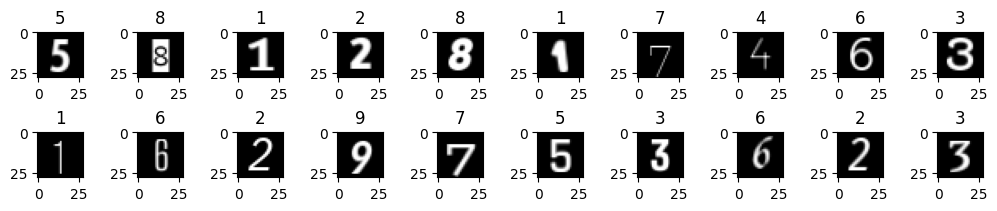

In [4]:
def view(digits, labels, rows=1, cols=10, title=None):
    fig, subs = plt.subplots(rows, cols, layout='constrained', figsize=(cols,rows + (0.25 if title else 0)), squeeze=False)
    if title:
        fig.suptitle(title)
    subs = [s for sub in subs for s in sub] 
    for digit, label, sub in zip(digits, labels, subs):
        sub.set_title(label)
        sub.imshow(digit, cmap='gray')

samples = np.random.choice(len(digits), 20)

view(digits[samples], labels[samples], rows=2)

2024-06-06 08:25:03.814607: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 08:25:03.856738: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 08:25:03.856766: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 08:25:03.859484: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 08:25:03.859511: I external/local_xla/xla/stream_executor

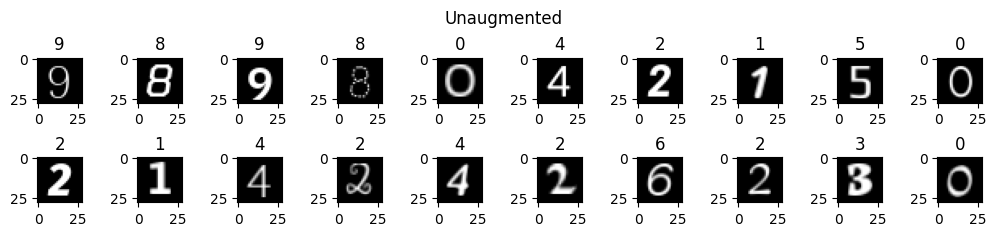

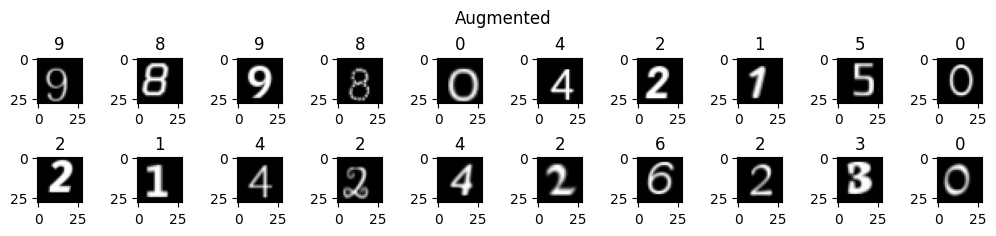

In [5]:
# As with digit recognition, it's only really the translations that are relevant (I add the 90/180/270 deg rotations later)
augmentations = keras.Sequential([
    # layers.RandomRotation(0.05),
    # layers.RandomZoom((-0.2, 0), (-0.2, 0), fill_mode="constant", fill_value=0),
    layers.RandomTranslation((-0.1, 0.1), (-0.1, 0.1), fill_mode="constant", fill_value=0),
])

samples = np.random.choice(len(digits), 20)

augmented_digits = augmentations(digits[samples])

view(digits[samples], labels[samples], title="Unaugmented", rows=2)
view(augmented_digits, labels[samples], title="Augmented", rows=2)

In [6]:
# As a n00b I have no idea how to do this not in memory...
x = np.concatenate([digits] + [augmentations(digits) for _ in range(4)])

p = np.random.permutation(len(x))
x = x[p]

print("Digits after augmentation:", len(x))

Digits after augmentation: 149500


Digits with rotations: 598000


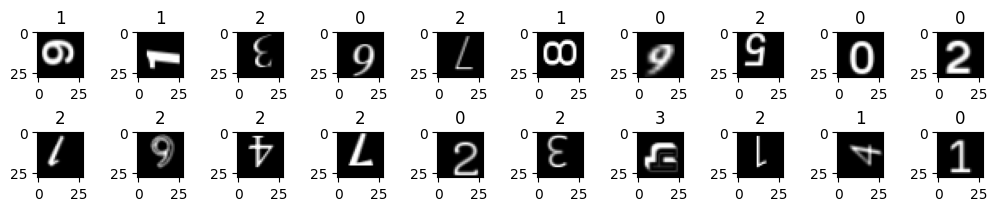

In [7]:
def add_orientations(x):
    length = len(x)
    x = np.concatenate([
        np.array([np.rot90(d, k=i) for d in x])
        for i in range(4)
    ])
    y = np.concatenate([np.full((length,), i) for i in range(4)])

    assert len(x) == len(y)
    
    p = np.random.permutation(len(x))
    return x[p], y[p]

x, y = add_orientations(x)

samples = np.random.choice(len(digits), 20)

print("Digits with rotations:", len(x))
view(x[samples], y[samples], rows=2)

In [8]:
TRAINING_SET = 0.8
r = np.random.default_rng(seed=12345)
training_mask = np.fromiter((r.random() <= TRAINING_SET for _ in range(len(x))), dtype=bool)

x_train = x[training_mask]
x_test = x[~training_mask]

y_train = keras.utils.to_categorical(y[training_mask], 4)
y_test = keras.utils.to_categorical(y[~training_mask], 4)

print("Training samples:", len(x_train))
print("Test samples:", len(x_test))

Training samples: 478524
Test samples: 119476


In [9]:
model = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        # layers.Dropout(0.5),
        # layers.Dense(64, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(4, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         6,404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,220 (98.52 KB)

 Trainable params: 25,220 (98.52 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
batch_size = 10000
# Something about "early exit" to help optimise the count of epoch?
epochs = 100

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/100


I0000 00:00:1717662346.215411    5483 service.cc:145] XLA service 0x1210bfa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717662346.216711    5483 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-06-06 08:25:46.309828: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-06 08:25:46.668772: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


 4/44 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.2881 - loss: 1.3735

I0000 00:00:1717662354.133004    5483 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 0.5145 - loss: 1.1057 - val_accuracy: 0.7360 - val_loss: 0.6191
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.7202 - loss: 0.6286 - val_accuracy: 0.7967 - val_loss: 0.4968
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7777 - loss: 0.5110 - val_accuracy: 0.8268 - val_loss: 0.4215
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8068 - loss: 0.4506 - val_accuracy: 0.8401 - val_loss: 0.3859
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8208 - loss: 0.4161 - val_accuracy: 0.8508 - val_loss: 0.3605
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8294 - loss: 0.3953 - val_accuracy: 0.8539 - val_loss: 0.3473
Epoch 7/100
 3/44 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8353 - loss: 0.3831

2024-06-06 08:26:16.141431: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 31520000 bytes after encountering the first element of size 31520000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8353 - loss: 0.3798 - val_accuracy: 0.8559 - val_loss: 0.3409
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8389 - loss: 0.3715 - val_accuracy: 0.8620 - val_loss: 0.3282
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8418 - loss: 0.3613 - val_accuracy: 0.8643 - val_loss: 0.3211
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8447 - loss: 0.3540 - val_accuracy: 0.8676 - val_loss: 0.3149
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8483 - loss: 0.3475 - val_accuracy: 0.8676 - val_loss: 0.3115
Epoch 12/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8496 - loss: 0.3450 - val_accuracy: 0.8700 - val_loss: 0.3069
Epoch 13/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8510 - loss: 0.3397 - val_accuracy: 0.8713 - val_loss: 0.3031
Epoch 14/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8531 - loss: 0.3358 - val_accuracy: 0.8726 - 

2024-06-06 08:28:47.331035: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 31520000 bytes after encountering the first element of size 31520000 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8798 - loss: 0.2619 - val_accuracy: 0.8935 - val_loss: 0.2329
Epoch 88/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8800 - loss: 0.2614 - val_accuracy: 0.8935 - val_loss: 0.2319
Epoch 89/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8809 - loss: 0.2603 - val_accuracy: 0.8936 - val_loss: 0.2311
Epoch 90/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8813 - loss: 0.2600 - val_accuracy: 0.8941 - val_loss: 0.2311
Epoch 91/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8801 - loss: 0.2606 - val_accuracy: 0.8947 - val_loss: 0.2300
Epoch 92/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8807 - loss: 0.2599 - val_accuracy: 0.8940 - val_loss: 0.2313
Epoch 93/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8809 - loss: 0.2596 - val_accuracy: 0.8945 - val_loss: 0.2300
Epoch 94/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8821 - loss: 0.2582 - val_accuracy: 0.8946 

In [11]:
score = model.evaluate(x_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

3734/3734 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8978 - loss: 0.2248
Test loss: 0.2279181331396103
Test accuracy: 0.8953095078468323


In [12]:
import time
model.save(f"models/orientations_{int(score[1] * 10000)}_{int(score[0] * 10000):04}_{int(time.time())}.keras")